# Imports

In [64]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Activation, Input, Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix
from percolation import read_percolation_data
from sklearn.model_selection import train_test_split
import sys

# Loading Data

In [9]:
L = 128
pc = 0.59274
#p_arr = np.round(np.arange(0, 1.0, 0.01), 4)
#p_arr = np.round(np.array([0.57, 0.58, 0.61, 0.62]), 4)
p_arr = np.round(np.array([0.2 , 0.9]), 4)
p_arr = np.append(p_arr, pc)

In [10]:
X, y = read_percolation_data(L, p_arr, pc, max_configs_per_p=1000)

In [11]:
print(X.shape, y.shape)

(3000, 128, 128, 1) (3000,)


In [12]:
N = X.shape[0]
L = X.shape[1] 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [14]:
print('X.shape:', X.shape, ', y.shape:', y.shape)
print('X_train.shape:', X_train.shape, ', y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape, ', y_test.shape:', y_test.shape)

X.shape: (3000, 128, 128, 1) , y.shape: (3000,)
X_train.shape: (2400, 128, 128, 1) , y_train.shape: (2400,)
X_test.shape: (600, 128, 128, 1) , y_test.shape: (600,)


In [15]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 2


# Defining and training the AutoEncoder

In [16]:
latent_space_dimension = 10

In [94]:
def custom_activation(x):
    return (K.sigmoid(x) * 2) - 1

In [118]:
class AutoEncoder(Model):
  def __init__(self, L, latent_space_dimension):
    super(AutoEncoder, self).__init__()
    
    self.encoder = tf.keras.Sequential([
      Input(shape=(L, L, 1)), 
      Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      Conv2D(latent_space_dimension, (3,3), activation='relu', padding='same', strides=2),
      BatchNormalization()])
    
    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(latent_space_dimension, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2D(1, kernel_size=(3,3), activation=custom_activation, padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [119]:
autoencoder = AutoEncoder(L, latent_space_dimension)

In [120]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [121]:
r = autoencoder.fit(X_train, X_train, epochs=15, validation_data=(X_test, X_test))

Epoch 1/15
75/75 [==============================] - 48s 637ms/step - loss: 0.9078 - val_loss: 0.7293
Epoch 2/15
75/75 [==============================] - 48s 639ms/step - loss: 0.7227 - val_loss: 0.7147
Epoch 3/15
75/75 [==============================] - 49s 655ms/step - loss: 0.7211 - val_loss: 0.7138
Epoch 4/15
75/75 [==============================] - 49s 660ms/step - loss: 0.7213 - val_loss: 0.7136
Epoch 5/15
75/75 [==============================] - 50s 670ms/step - loss: 0.7208 - val_loss: 0.7145
Epoch 6/15
75/75 [==============================] - 49s 658ms/step - loss: 0.7208 - val_loss: 0.7139
Epoch 7/15
75/75 [==============================] - 49s 649ms/step - loss: 0.7213 - val_loss: 0.7143
Epoch 8/15
75/75 [==============================] - 50s 662ms/step - loss: 0.7207 - val_loss: 0.7131
Epoch 9/15
75/75 [==============================] - 40s 535ms/step - loss: 0.7208 - val_loss: 0.7136
Epoch 10/15
75/75 [==============================] - 40s 528ms/step - loss: 0.7207 - val_lo

In [122]:
autoencoder.encoder.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 2, 2, 128)         147584    
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 1, 1, 10)        

In [123]:
autoencoder.decoder.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_96 (Conv2DT (None, 2, 2, 10)          910       
_________________________________________________________________
conv2d_transpose_97 (Conv2DT (None, 4, 4, 128)         11648     
_________________________________________________________________
conv2d_transpose_98 (Conv2DT (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_transpose_99 (Conv2DT (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_100 (Conv2D (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_101 (Conv2D (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_102 (Conv2D (None, 128, 128, 32)    

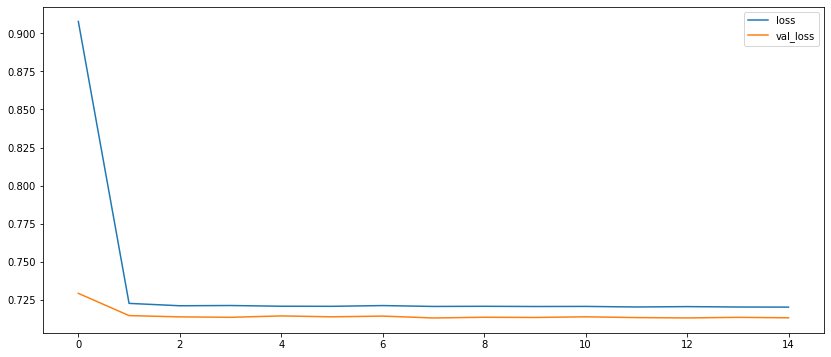

In [124]:
plt.figure(figsize=(14,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [125]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [127]:
encoded_imgs = autoencoder.encoder([X[0], X[-1]]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

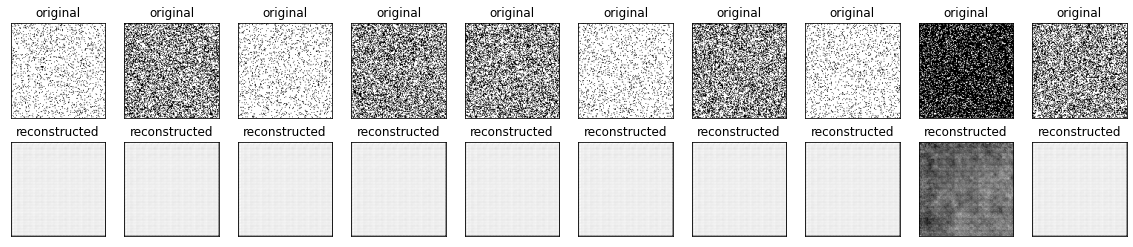

In [126]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()